In [1]:
import os
import math
import random #to set the seed to replicate results
from datetime import datetime,timedelta #for today's date
from dateutil.relativedelta import relativedelta
import sys
import requests

from targets_plot_generator.src import generate_plot

import psycopg2
import psycopg2.extras
from psycopg2.extensions import AsIs

import pandas as pd 
import numpy as np #for the e_logarithmic filter (and also some other mathematical operations)
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import RobustScaler #for preprocessing, it scales features using statistics that are robust to outliers.
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress #for the slope and the value of Y at X=0 of the linear trend line
from scipy.optimize import curve_fit
import tsmoothie #for the Kalman filter, it is an efficient recursive filter that evaluates the state of a dynamic system starting from a series of measurements subject to noise.

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM,Conv1D,MaxPooling1D,Flatten,TimeDistributed #the two main layers of the model
from tensorflow.keras.optimizers import Adam#for the training of the model
from tensorflow.keras.models import load_model

random.seed(42)  #set the seed to replicate results

pd.options.display.max_columns = None

plt.style.use('ggplot')
plt.rc(
    'figure',
    autolayout=True,
    figsize=(11,4)
)

plt.rc(
    'axes',
    labelweight='bold',
    labelsize='large',
    titleweight='bold',
    titlesize=20,
    titlepad=10
)

print(tf.config.list_physical_devices('GPU'))

2024-01-27 14:46:17.766766: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-27 14:46:18.397625: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-27 14:46:18.400201: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-27 14:46:20.275625: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[]


### Preprocess Config

In [37]:
'''This is the timestep which indicates the window size'''
#model_case_version_time_steps= '10'
'''This is the number of periods defined in the target(MPNxP) where x is the number of periods'''
model_case_version_main_target_code='5'

#today = '20220706'
today = datetime.today().strftime('%Y%m%d') #just for names of files (for now)
print('Today is', today)

''' Here, we define the case name'''
case = 'TSLA'
print(case)

'''Here, we define the list of targets we are going to work on and also the average for each target (this value is used during the training for normalization\rescaling of some analytical parameters)'''
targets =['MPN'+model_case_version_main_target_code+'P']  #this must be changed whenever tha targets change

dataset_start_date = '2020-01-01'
train_end_date = "2023-09-29"
validation_end_date="2023-12-31"
#test_end_date="2023-12-31"

Today is 20240126
TSLA


## LBM 0.02 Before the Train

### Utils

In [38]:
'''Function for making sequences (blocks) of test and train data'''
def building_data_sequences(data_X,data_Y, timesteps): #timesteps means how many days we consider for each block

    X=[]
    y_MPNxP = []
    for i in range(len(data_X)-timesteps+1):  #how it works: every timesteps (e.g. 10 days) a block is constituted and for each block data and true values are stored
        X.append(data_X[i:(i+timesteps),:])
        y_MPNxP.append(data_Y[i+timesteps-1])
    return np.array(X), [np.array(y_MPNxP)]

'''Function for computing the analytical parameters'''
def sir_parameters(x,y): #sir stands for slope, intercept, rvalue (actually there's also the average trend line distance or avg_tld, but it came later)

  analytical_params = linregress(x, y)
  slope = analytical_params.slope
  intercept = analytical_params.intercept
  rvalue = analytical_params.rvalue #pay attention that here we have the correlaton coefficient (so not r2 that is the coefficient of determination)
  x_trend_line = slope*x + intercept #this is computed just for the avg_tld
  avg_trend_line_distance = np.mean(np.abs(x_trend_line-y))
  return slope,intercept,rvalue**2,avg_trend_line_distance

def custom_loss_function(attenuated_padding_value):

  def padding_loss_function(y_true, y_pred):

    y_pred = tf.multiply(y_pred, attenuated_padding_value) #this is the multiplication between the predictions and the attenuated_padding_value

    squared_difference = tf.square(y_true - y_pred)

    return tf.reduce_mean(squared_difference, axis=-1) #mse

  return padding_loss_function

def train_validation_test_split(dataframe,train_end_date,validation_end_date,test_end_date=None):
    # Define train period
    dataframe_start_date = dataframe['DATE'].min()

    train_end_date = pd.Timestamp(train_end_date)
    train_end_idx = dataframe.index[dataframe['DATE'] == train_end_date].values[0]
    train_end_idx = train_end_idx-int(model_case_version_main_target_code)

    # Define Validation period
    validation_start_date = (train_end_date + pd.Timedelta(days=1))
    validation_end_date = pd.Timestamp(validation_end_date)

    # Define Test Period
    #test_start_date = (validation_end_date + pd.Timedelta(days=1))
    #test_end_date = pd.Timestamp(test_end_date)

    #Split
    train_df = dataframe.iloc[int(model_case_version_main_target_code):train_end_idx+1]
    validation_df = dataframe.loc[(dataframe['DATE'] >= validation_start_date) & (dataframe['DATE'] <= validation_end_date)]
    #test_df = dataframe.loc[(dataframe['DATE'] >= test_start_date) & (dataframe['DATE'] <= test_end_date)]

    train_period = str(train_df['DATE'].min().date()) + ' / ' + str(train_df['DATE'].max().date())
    print('Train Period: ', train_period)

    validation_period = str(validation_df['DATE'].min().date()) + ' / ' + str(validation_df['DATE'].max().date())
    print('Validation Period: ', validation_period)

    #test_period = str(test_df['DATE'].min().date()) + ' / ' + str(test_df['DATE'].max().date())
    #print('Test Period: ', test_period)

    print('\n')
    print('Train shape: ', train_df.shape)
    print('Validation shape: ', validation_df.shape)
    #print('Test shape: ', test_df.shape)

    return train_df,validation_df


def plot_model_history(history: pd.DataFrame, limit_x = [None,None], limit_y = [None,None]):
   ax = history['loss'].plot(label='Train Loss')
   history['val_loss'].plot(ax=ax, label='Validation Loss')

   ax.set_xlim(limit_x)
   ax.set_ylim(limit_y)
   plt.legend()
   plt.show()   

### Analytical Parameters

In [39]:
#1L = dispersion = 1
#4L = slope + intercept + resqr + dispersion = 1
#5L = all the weighting = 1
#new paramaters case = intercept + slope + end intercept + correlation + dispersion
slope_weighting_exponent_ratio = 1
intercept_weighting_exponent_ratio = 1
end_intercept_weighting_exponent_ratio = 0
rsqr_weighting_exponent_ratio = 1
dispersion_weighting_exponent_ratio = 3

slope_weighting_exponent_predicted_actual = 0
intercept_weighting_exponent_predicted_actual = 0
rsqr_weighting_exponent_predicted_actual = 0
dispersion_weighting_exponent_predicted_actual = 0

analytical_parametrs = str(intercept_weighting_exponent_ratio)+str(slope_weighting_exponent_ratio)+str(end_intercept_weighting_exponent_ratio)+str(rsqr_weighting_exponent_ratio)+str(dispersion_weighting_exponent_ratio)
print(analytical_parametrs)

11013


### Extracting Dataset

In [40]:
''' Conection to PostgreSQL '''
# The credentials to conect to the database
hostname = 'database-1.ctzm0hf7fhri.eu-central-1.rds.amazonaws.com'
database = 'dyDATA_new'
username = 'postgres'
pwd = 'Proc2023awsrdspostgresql'
port_id = 5432
conn = None

#this helps to retreive the data for a particular asset from the database
asset_script="SELECT * FROM "+'\"'+"ASSET_"+case+'\"'+".features_targets_input_view WHERE features_targets_input_view."+'\"'+"cleaned_raw_features_environment_PK"+'\"'+ "= 4"
asset_script

''' The active financial assets '''
# Here we select the active financial asset from the financial asset list table
try:
  with psycopg2.connect(
      host = hostname,
      dbname = database,
      user = username,
      password = pwd,
      port = port_id
  ) as conn:

    with conn.cursor(cursor_factory=psycopg2.extras.DictCursor) as cur:
        print('You are connect to the Database:',database)
        select_script = asset_script # do not forget to set to asset_script when data has been uploaded
        cur.execute(select_script)
        data = cur.fetchall()
        cols = []
        # loop to create the dataframe that contains the active financial assets
        for rec in cur.description:
            cols.append(rec[0])
        dohlcav_mpnxp_data= pd.DataFrame(data = data, columns = cols)
        print('Your SQL has executed successfully')

except Exception as error:
  print(error)

finally:
  if conn is not None:
     conn.close()

if case=='TSLA':
  dohlcav_mpnxp_data = dohlcav_mpnxp_data.loc[dohlcav_mpnxp_data['cleaned_raw_features_DCP_date_current_period'] >= dataset_start_date].reset_index(drop=True)

dohlcav_mpnxp_data.head()

You are connect to the Database: dyDATA_new
Your SQL has executed successfully


,cleaned_raw_features_id,cleaned_raw_features_DCP_date_current_period,calculated_features_DNCP,cleaned_raw_features_OPCP_open_price_current_period,cleaned_raw_features_HPCP_high_price_current_period,cleaned_raw_features_LPCP_low_price_current_period,cleaned_raw_features_CPCP_close_price_current_period,cleaned_raw_features_ACPCP_adjusted_close_price_current_period,cleaned_raw_features_VTCP_volume_of_transactions_current_period,cleaned_raw_features_environment_PK,calculated_targets_MPN1P,calculated_targets_HPN1P,calculated_targets_LPN1P,calculated_targets_MPN2P,calculated_targets_HPN2P,calculated_targets_LPN2P,calculated_targets_MPN3P,calculated_targets_HPN3P,calculated_targets_LPN3P,calculated_targets_MPN4P,calculated_targets_HPN4P,calculated_targets_LPN4P,calculated_targets_MPN5P,calculated_targets_HPN5P,calculated_targets_LPN5P,calculated_targets_MPN6P,calculated_targets_HPN6P,calculated_targets_LPN6P,calculated_targets_MPN7P,calculated_targets_HPN7P,calculated_targets_LPN7P,calculated_targets_MPN10P,calculated_targets_HPN10P,calculated_targets_LPN10P,calculated_targets_MPN20P,calculated_targets_HPN20P,calculated_targets_LPN20P,calculated_targets_environment_PK
0,2330,2020-01-02,43832.0,28.300000,28.713333,28.114000,28.684000,28.684000,142981500.0,4,29.534000,30.266666,29.128000,29.553917,30.266666,29.128000,30.102667,31.442000,29.128000,30.245333,33.232666,29.128000,30.924166,33.253334,29.128000,31.356333,33.253334,29.128000,31.580000,35.042,29.128000,32.415584,36.49400,29.128000,35.272333,43.533333,29.128000,4
1,2331,2020-01-03,43833.0,29.366667,30.266666,29.128000,29.534000,29.534000,266677500.0,4,29.726167,30.104000,29.333332,30.164000,31.442000,29.333332,30.924166,33.232666,29.333332,31.356333,33.253334,29.333332,31.580000,33.253334,29.333332,31.926500,35.042000,29.333332,32.119330,36.494,29.333332,32.908334,36.49400,29.333332,35.907750,52.409332,29.333332,4
2,2332,2020-01-06,43836.0,29.364668,30.104000,29.333332,30.102667,30.102667,151995010.0,4,30.924166,31.442000,30.224000,31.356333,33.232666,30.224000,31.580000,33.253334,30.224000,31.926500,33.253334,30.224000,32.119330,35.042000,30.224000,32.415584,36.494000,30.224000,32.809334,36.494,30.224000,33.554250,36.57200,30.224000,36.487000,64.599335,30.224000,4
3,2333,2020-01-07,43837.0,30.760000,31.442000,30.224000,31.270666,31.270666,268231500.0,4,32.209333,33.232666,31.215334,32.355584,33.253334,31.215334,32.119330,33.253334,31.215334,32.415584,35.042000,31.215334,32.809334,36.494000,31.215334,33.186333,36.494000,31.215334,33.232666,36.494,31.215334,34.132999,39.63333,31.215334,37.120666,64.599335,31.215334,4
4,2334,2020-01-08,43838.0,31.580000,33.232666,31.215334,32.809334,32.809334,467164500.0,4,32.501834,33.253334,31.524668,32.104332,33.253334,31.524668,32.501834,35.042000,31.524668,33.020000,36.494000,31.524668,33.933166,36.494000,31.524668,33.748833,36.494000,31.524668,33.933166,36.494,31.524668,34.778666,39.63333,31.524668,37.642000,64.599335,31.524668,4


### Filtering and Cleaning the Data

In [41]:
# FILTERING
filtered_columns_1=list(dohlcav_mpnxp_data.columns[:9])#to filter out the dates columns and features columns
filtered_columns_2=[x for x in dohlcav_mpnxp_data.columns if  targets[0][3:] in x ]#feature out the main target columns

if model_case_version_main_target_code=='1':
  temp=filtered_columns_2[0]
  temp_2=filtered_columns_2[1]
  filtered_columns_2[0]=filtered_columns_2[2]
  filtered_columns_2[1]=temp
  filtered_columns_2[2]=temp_2

#to add the last two constant columns to the table
filtered_columns_3=['calculated_targets_HPN1P','calculated_targets_LPN1P']
filtered_columns=filtered_columns_1+filtered_columns_2+filtered_columns_3
print(filtered_columns)
dohlcav_mpnxp_data=dohlcav_mpnxp_data[filtered_columns]

# RENAMING
if model_case_version_main_target_code=='1':
  dohlcav_mpnxp_data.columns=["ID","DCP_date_current_period","DNCP_day_number_current_period","OPCP_open_price_current_period","HPCP_high_price_current_period","LPCP_low_price_current_period"
,"CPCP_close_price_current_period","ACPCP_adjusted_close_price_current_period","VTCP_volume_of_transactions_current_period","MPN"+model_case_version_main_target_code+"P_median_price_next_"+model_case_version_main_target_code+"_periods","HPN"+model_case_version_main_target_code+"P_highest_price_next_"+model_case_version_main_target_code+"_periods","LPN"+model_case_version_main_target_code+"P_lowest_price_next_"+model_case_version_main_target_code+"_periods","HPN1P_high_price_next_1_period",
"LPN1P_low_price_next_1_period"
]
else:
  dohlcav_mpnxp_data = dohlcav_mpnxp_data.rename(columns={"cleaned_raw_features_id":"ID",
                                "cleaned_raw_features_DCP_date_current_period": "DCP_date_current_period",
                                "calculated_features_DNCP":"DNCP_day_number_current_period",
                                "cleaned_raw_features_OPCP_open_price_current_period":"OPCP_open_price_current_period",
                                "cleaned_raw_features_HPCP_high_price_current_period":"HPCP_high_price_current_period",
                                "cleaned_raw_features_LPCP_low_price_current_period":"LPCP_low_price_current_period",
                                "cleaned_raw_features_CPCP_close_price_current_period": "CPCP_close_price_current_period",
                                "cleaned_raw_features_ACPCP_adjusted_close_price_current_period":"ACPCP_adjusted_close_price_current_period",
                                "cleaned_raw_features_VTCP_volume_of_transactions_current_period":"VTCP_volume_of_transactions_current_period",
                                filtered_columns_2[0]:"MPN"+model_case_version_main_target_code+"P_median_price_next_"+model_case_version_main_target_code+"_periods",
                                filtered_columns_2[1]:"HPN"+model_case_version_main_target_code+"P_highest_price_next_"+model_case_version_main_target_code+"_periods",
                                filtered_columns_2[2]:"LPN"+model_case_version_main_target_code+"P_lowest_price_next_"+model_case_version_main_target_code+"_periods",
                                filtered_columns_3[0]:"HPN1P_high_price_next_1_period",
                                filtered_columns_3[1]:"LPN1P_low_price_next_1_period",
                                })
  
dohlcav_mpnxp_data.head()

['cleaned_raw_features_id', 'cleaned_raw_features_DCP_date_current_period', 'calculated_features_DNCP', 'cleaned_raw_features_OPCP_open_price_current_period', 'cleaned_raw_features_HPCP_high_price_current_period', 'cleaned_raw_features_LPCP_low_price_current_period', 'cleaned_raw_features_CPCP_close_price_current_period', 'cleaned_raw_features_ACPCP_adjusted_close_price_current_period', 'cleaned_raw_features_VTCP_volume_of_transactions_current_period', 'calculated_targets_MPN5P', 'calculated_targets_HPN5P', 'calculated_targets_LPN5P', 'calculated_targets_HPN1P', 'calculated_targets_LPN1P']


,ID,DCP_date_current_period,DNCP_day_number_current_period,OPCP_open_price_current_period,HPCP_high_price_current_period,LPCP_low_price_current_period,CPCP_close_price_current_period,ACPCP_adjusted_close_price_current_period,VTCP_volume_of_transactions_current_period,MPN5P_median_price_next_5_periods,HPN5P_highest_price_next_5_periods,LPN5P_lowest_price_next_5_periods,HPN1P_high_price_next_1_period,LPN1P_low_price_next_1_period
0,2330,2020-01-02,43832.0,28.300000,28.713333,28.114000,28.684000,28.684000,142981500.0,30.924166,33.253334,29.128000,30.266666,29.128000
1,2331,2020-01-03,43833.0,29.366667,30.266666,29.128000,29.534000,29.534000,266677500.0,31.580000,33.253334,29.333332,30.104000,29.333332
2,2332,2020-01-06,43836.0,29.364668,30.104000,29.333332,30.102667,30.102667,151995010.0,32.119330,35.042000,30.224000,31.442000,30.224000
3,2333,2020-01-07,43837.0,30.760000,31.442000,30.224000,31.270666,31.270666,268231500.0,32.809334,36.494000,31.215334,33.232666,31.215334
4,2334,2020-01-08,43838.0,31.580000,33.232666,31.215334,32.809334,32.809334,467164500.0,33.933166,36.494000,31.524668,33.253334,31.524668


In [42]:
''' This comprises the list of target in our datasets'''
targets_list=["MPN"+model_case_version_main_target_code+"P_median_price_next_"+model_case_version_main_target_code+"_periods",
                        "HPN"+model_case_version_main_target_code+"P_highest_price_next_"+model_case_version_main_target_code+"_periods",
                        "LPN"+model_case_version_main_target_code+"P_lowest_price_next_"+model_case_version_main_target_code+"_periods",
                        'HPN1P_high_price_next_1_period','LPN1P_low_price_next_1_period']

for i in targets_list:
  if targets[0] in i:
    main_target_column=i

''' What is stop target?'''
stop_target=dohlcav_mpnxp_data.index[-1]+1

#pay attention here because everytime targets change, also the name of the columns change
df = dohlcav_mpnxp_data.drop(["ID"], axis=1)

#pay attention here because everytime targets change, also the name of the columns change
df = df.rename(columns={"DCP_date_current_period": "DATE",
                        "DNCP_day_number_current_period": "DNCP",
                        "OPCP_open_price_current_period":"OPCP",
                        "HPCP_high_price_current_period":"HPCP",
                        "LPCP_low_price_current_period":"LPCP",
                        "CPCP_close_price_current_period":"CPCP",
                        "ACPCP_adjusted_close_price_current_period": "ACPCP",
                        "VTCP_volume_of_transactions_current_period":"VTCP",
                        "MPN"+model_case_version_main_target_code+"P_median_price_next_"+model_case_version_main_target_code+"_periods":"MPN"+model_case_version_main_target_code+"P",
                        "HPN"+model_case_version_main_target_code+"P_highest_price_next_"+model_case_version_main_target_code+"_periods":"HPN"+model_case_version_main_target_code+"P",
                        "LPN"+model_case_version_main_target_code+"P_lowest_price_next_"+model_case_version_main_target_code+"_periods":"LPN"+model_case_version_main_target_code+"P",
                        'HPN1P_high_price_next_1_period':'hpn1p',
                        'LPN1P_low_price_next_1_period':'lpn1p'})

#df = df.set_index('DATE')
#df.index = pd.to_datetime(df.index)
df['DATE'] = pd.to_datetime(df['DATE'])

df.head()

,DATE,DNCP,OPCP,HPCP,LPCP,CPCP,ACPCP,VTCP,MPN5P,HPN5P,LPN5P,hpn1p,lpn1p
0,2020-01-02,43832.0,28.300000,28.713333,28.114000,28.684000,28.684000,142981500.0,30.924166,33.253334,29.128000,30.266666,29.128000
1,2020-01-03,43833.0,29.366667,30.266666,29.128000,29.534000,29.534000,266677500.0,31.580000,33.253334,29.333332,30.104000,29.333332
2,2020-01-06,43836.0,29.364668,30.104000,29.333332,30.102667,30.102667,151995010.0,32.119330,35.042000,30.224000,31.442000,30.224000
3,2020-01-07,43837.0,30.760000,31.442000,30.224000,31.270666,31.270666,268231500.0,32.809334,36.494000,31.215334,33.232666,31.215334
4,2020-01-08,43838.0,31.580000,33.232666,31.215334,32.809334,32.809334,467164500.0,33.933166,36.494000,31.524668,33.253334,31.524668


### Feature Engineering

In [43]:
base_target_code = 'MPN' + model_case_version_main_target_code + 'P'
base_target_column_index = df.columns.get_loc(base_target_code)

def new_target_column(target_code , shift_back_period):
  prev_target = df[target_code]
  new_target = prev_target[:-shift_back_period]
  first_dates_handling = [0] * shift_back_period
  new_target=np.concatenate((first_dates_handling,new_target))
  return new_target

#Adding multiple targets
new_target_index = base_target_column_index
for i in range(int(model_case_version_main_target_code)):
  new_target_code = 'MPN-' + str(i+1) + 'P'
  df.insert(new_target_index+1,new_target_code,new_target_column(base_target_code,i+1))
  new_target_index = new_target_index + 1
  targets.append(new_target_code)


# '''Ratio Transformation for features'''
df.insert(7,'OPCP_Ratio',df['OPCP']/df['CPCP'])
df.insert(8,'HPCP_Ratio',df['HPCP']/df['CPCP'])
df.insert(9,'LPCP_Ratio',df['LPCP']/df['CPCP'])
df.insert(10,'ACPCP_Ratio',df['ACPCP']/df['CPCP'])
df.insert(df.columns.get_loc('MPN'+model_case_version_main_target_code+'P') ,'MPN'+ model_case_version_main_target_code +'P_Ratio',df['MPN'+ model_case_version_main_target_code +'P'].shift(5)/df['CPCP'].shift(5))
df.insert(df.columns.get_loc('HPN'+model_case_version_main_target_code+'P'),'HPN'+ model_case_version_main_target_code +'P_Ratio',df['HPN'+ model_case_version_main_target_code +'P']/df['CPCP'])
df.insert(df.columns.get_loc('LPN'+model_case_version_main_target_code+'P'),'LPN'+ model_case_version_main_target_code +'P_Ratio',df['LPN'+ model_case_version_main_target_code +'P']/df['CPCP'])
df.insert(df.columns.get_loc('hpn1p')+1,'hpn1p_Ratio',df['hpn1p']/df['CPCP'])
df.insert(df.columns.get_loc('lpn1p')+1,'lpn1p_Ratio',df['lpn1p']/df['CPCP'])

df = df.iloc[int(model_case_version_main_target_code):]

df.head()

,DATE,DNCP,OPCP,HPCP,LPCP,CPCP,ACPCP,OPCP_Ratio,HPCP_Ratio,LPCP_Ratio,ACPCP_Ratio,VTCP,MPN5P_Ratio,MPN5P,MPN-1P,MPN-2P,MPN-3P,MPN-4P,MPN-5P,HPN5P_Ratio,HPN5P,LPN5P_Ratio,LPN5P,hpn1p,hpn1p_Ratio,lpn1p,lpn1p_Ratio
5,2020-01-09,43839.0,33.140000,33.253334,31.524668,32.089333,32.089333,1.032742,1.036274,0.982403,1.0,426606020.0,1.078098,34.297333,33.933166,32.809334,32.119330,31.580000,30.924166,1.137263,36.49400,0.984128,31.580000,32.329334,1.007479,31.580000,0.984128
6,2020-01-10,43840.0,32.119330,32.329334,31.580000,31.876667,31.876667,1.007613,1.014201,0.990693,1.0,194392500.0,1.069276,34.378000,34.297333,33.933166,32.809334,32.119330,31.580000,1.144850,36.49400,1.028966,32.800000,35.042000,1.099299,32.800000,1.028966
7,2020-01-13,43843.0,32.900000,35.042000,32.800000,34.990665,34.990665,0.940251,1.001467,0.937393,1.0,397764000.0,1.066993,34.993332,34.378000,34.297333,33.933166,32.809334,32.119330,1.045193,36.57200,0.937717,32.811333,36.494000,1.042964,34.993332,1.000076
8,2020-01-14,43844.0,36.284000,36.494000,34.993332,35.861332,35.861332,1.011786,1.017642,0.975796,1.0,434943000.0,1.049205,35.048167,34.993332,34.378000,34.297333,33.933166,32.809334,1.105183,39.63333,0.914950,32.811333,35.856000,0.999851,34.452667,0.960719
9,2020-01-15,43845.0,35.317333,35.856000,34.452667,34.566666,34.566666,1.021716,1.037300,0.996702,1.0,260532000.0,1.034253,35.907333,35.048167,34.993332,34.378000,34.297333,33.933166,1.146577,39.63333,0.949219,32.811333,34.297333,0.992208,32.811333,0.949219


### Train Validation Test Split

In [44]:
train_df,validation_df = train_validation_test_split(dataframe=df,
                                                             train_end_date=train_end_date,
                                                             validation_end_date=validation_end_date,
                                                             #test_end_date=test_end_date
                                                            )

train_actual_target_list = train_df['MPN'+model_case_version_main_target_code+'P'].to_numpy(dtype='float64')
validation_actual_target_list = validation_df['MPN'+model_case_version_main_target_code+'P'].to_numpy(dtype='float64')
#test_actual_target_list = test_df['MPN'+model_case_version_main_target_code+'P'].to_numpy(dtype='float64')

Train Period:  2020-01-16 / 2023-09-29
Validation Period:  2023-10-02 / 2023-12-29


Train shape:  (933, 27)
Validation shape:  (63, 27)


### Pretreatment

In [45]:
features_start_index = 1
features_stop_index = 13

features = list(train_df.iloc[:,features_start_index:features_stop_index].columns)
targets = list(train_df.iloc[:,features_stop_index:features_stop_index + int(model_case_version_main_target_code) + 1].columns)

features_and_targets = features + targets

print('Features and Targets: ', features_and_targets)
print('Features List: ', features)
print('Targets List: ',targets)


train_dates_np_arr = train_df['DATE'].values
validation_dates_np_arr = validation_df['DATE'].values
#test_dates_np_arr = test_df['DATE'].values


train_df = train_df.set_index('DATE')
validation_df = validation_df.set_index('DATE')
#test_df = test_df.set_index('DATE')

Features and Targets:  ['DNCP', 'OPCP', 'HPCP', 'LPCP', 'CPCP', 'ACPCP', 'OPCP_Ratio', 'HPCP_Ratio', 'LPCP_Ratio', 'ACPCP_Ratio', 'VTCP', 'MPN5P_Ratio', 'MPN5P', 'MPN-1P', 'MPN-2P', 'MPN-3P', 'MPN-4P', 'MPN-5P']
Features List:  ['DNCP', 'OPCP', 'HPCP', 'LPCP', 'CPCP', 'ACPCP', 'OPCP_Ratio', 'HPCP_Ratio', 'LPCP_Ratio', 'ACPCP_Ratio', 'VTCP', 'MPN5P_Ratio']
Targets List:  ['MPN5P', 'MPN-1P', 'MPN-2P', 'MPN-3P', 'MPN-4P', 'MPN-5P']


#### Log Transform

In [46]:
train_df = np.log(train_df[features_and_targets])
validation_df = np.log(validation_df[features_and_targets])
#test_df = np.log(test_df[features_and_targets])

#### Kalman Filter

In [47]:
def kalman_filter(dataframe):
    kalman_smoother=tsmoothie.KalmanSmoother(component='level_trend',  component_noise={'level':0.1, 'trend':0.1})
    kalman_smoother.smooth(dataframe)
    dataframe = pd.DataFrame(kalman_smoother.smooth_data,columns=dataframe.columns,index=dataframe.index)
    return dataframe

train_df = kalman_filter(train_df[features_and_targets])
validation_df = kalman_filter(validation_df[features_and_targets])
#test_df = kalman_filter(test_df[features_and_targets])

#### Robust Scaling

In [48]:
'''
features = list(train_df.iloc[:,:12].columns)
targets = list(train_df.iloc[:,12:12+int(model_case_version_main_target_code)+1].columns)

print('Feaure List: ', features)
print('Target list: ', targets)

robust_scaler = RobustScaler()
train_df = pd.DataFrame(robust_scaler.fit_transform(train_df),columns=train_df.columns,index=train_df.index)
validation_df = pd.DataFrame(robust_scaler.transform(validation_df),columns=validation_df.columns, index=validation_df.index)
test_df = pd.DataFrame(robust_scaler.transform(test_df),columns=test_df.columns,index=test_df.index)
'''

# Fit transform train
robust_scaler_features = RobustScaler().fit(train_df[features])
robust_scaler_targets = RobustScaler().fit(train_df[targets])
 
train_df_features = pd.DataFrame(robust_scaler_features.transform(train_df[features]),
             columns=train_df[features].columns, index=train_df.index)


train_df_targets = pd.DataFrame(robust_scaler_targets.transform(train_df[targets]),
                                columns=train_df[targets].columns, index=train_df.index)

#Transform val
validation_df_features = pd.DataFrame(robust_scaler_features.transform(validation_df[features]),
                             columns=validation_df[features].columns, index=validation_df.index)

validation_df_targets = pd.DataFrame(robust_scaler_targets.transform(validation_df[targets]),
                             columns=validation_df[targets].columns, index=validation_df.index)

# Transform test
'''
test_df_features = pd.DataFrame(robust_scaler_features.transform(test_df[features]),
                             columns=test_df[features].columns, index=test_df.index)

test_df_targets = pd.DataFrame(robust_scaler_targets.transform(test_df[targets]),
                             columns=test_df[targets].columns, index=test_df.index)
'''

'\ntest_df_features = pd.DataFrame(robust_scaler_features.transform(test_df[features]),\n                             columns=test_df[features].columns, index=test_df.index)\n\ntest_df_targets = pd.DataFrame(robust_scaler_targets.transform(test_df[targets]),\n                             columns=test_df[targets].columns, index=test_df.index)\n'

## LMB 0.02 Model

### Model Hyperparameters

In [50]:
#this variable defines the path to save the results of the LMB
from pathlib import Path
ROOT = Path('/home/ubuntu/LTM_Bot/LTM-Long-short_Term_Memory.Bot-API_0.00')
MODEL_PATH = ROOT / 'models' / Path(case + '_SEPTEMBER_FIKRI')
PLOTS_PATH = ROOT / 'plots'

timesteps = 10
n_epochs = 100
batch = 64

MODEL_NAME = f'LSTM_CNN_Hybrid_T{timesteps}_E{n_epochs}_B{batch}_{dataset_start_date}.h5'
HIST_NAME = f'LSTM_CNN_Hybrid_T{timesteps}_E{n_epochs}_B{batch}_{dataset_start_date}_model_history.csv'

print(MODEL_PATH / MODEL_NAME)
print(MODEL_PATH / HIST_NAME)

train = True
save_model = False

'''These are the exponent used to define the number of nodes for each layer'''
twoexp_nodes_number_layer_1 = 7
twoexp_nodes_number_layer_2 = 10
twoexp_nodes_number_layer_3 = 7
twoexp_nodes_number_layer_4 = 6
twoexp_nodes_number_layer_5 = 0

lr=0.01 #learning rate
optimizer = Adam(learning_rate = lr)
attenuated_padding_value = 1

/home/ubuntu/LTM_Bot/LTM-Long-short_Term_Memory.Bot-API_0.00/models/TSLA_SEPTEMBER_FIKRI/LSTM_CNN_Hybrid_T10_E100_B64_2020-01-01.h5
/home/ubuntu/LTM_Bot/LTM-Long-short_Term_Memory.Bot-API_0.00/models/TSLA_SEPTEMBER_FIKRI/LSTM_CNN_Hybrid_T10_E100_B64_2020-01-01_model_history.csv


### Models

In [ ]:
def prediction_model_CNN_LSTM_hybrid(input_shape,optimizer,attenuated_padding_value):
    tf.keras.backend.clear_session()
    model = Sequential([
        TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'),input_shape=input_shape),
        TimeDistributed(MaxPooling1D(pool_size=2)),
        TimeDistributed(Flatten()),
        LSTM(2**twoexp_nodes_number_layer_1,return_sequences=True),
        LSTM(2**twoexp_nodes_number_layer_2,return_sequences=True),
        LSTM(2**twoexp_nodes_number_layer_3),
        Dense(2**twoexp_nodes_number_layer_4),
        Dense(int(model_case_version_main_target_code)+1)
    ])

    model.compile(optimizer=optimizer, loss=custom_loss_function(attenuated_padding_value))
    return model


def prediction_model_002(input_shape,optimizer,attenuated_padding_value):
    tf.keras.backend.clear_session()
    model = Sequential([
        LSTM(2**twoexp_nodes_number_layer_1,input_shape=input_shape,return_sequences=True),
        LSTM(2**twoexp_nodes_number_layer_2,return_sequences=True),
        LSTM(2**twoexp_nodes_number_layer_3),
        Dense(2**twoexp_nodes_number_layer_4),
        Dense(int(model_case_version_main_target_code)+1)
    ])

    model.compile(optimizer=optimizer, loss=custom_loss_function(attenuated_padding_value))
    return model

def model_cnn_lstm_v1(input_shape,optimizer,attenuated_padding_value):
    model = Sequential([
        Conv1D(filters=64,kernel_size=4,activation='relu',input_shape=input_shape),
        MaxPooling1D(),
        LSTM(2**twoexp_nodes_number_layer_1,return_sequences=True),
        LSTM(2**twoexp_nodes_number_layer_2,return_sequences=True),
        LSTM(2**twoexp_nodes_number_layer_3),
        Dense(2**twoexp_nodes_number_layer_4),
        Dense(int(model_case_version_main_target_code)+1)
    ])

    model.compile(optimizer=optimizer, loss=custom_loss_function(attenuated_padding_value))
    return model

def model_cnn_lstm_v2(input_shape,optimizer,attenuated_padding_value):
    model = Sequential([
        Conv1D(filters=64,kernel_size=2,activation='relu',input_shape=input_shape),
        MaxPooling1D(),
        LSTM(2**twoexp_nodes_number_layer_1,return_sequences=True),
        LSTM(2**twoexp_nodes_number_layer_2,return_sequences=True),
        LSTM(2**twoexp_nodes_number_layer_3),
        Dense(2**twoexp_nodes_number_layer_4),
        Dense(int(model_case_version_main_target_code)+1)
    ])

    model.compile(optimizer=optimizer, loss=custom_loss_function(attenuated_padding_value))
    return model

### Create Sequences 

In [51]:
train_features_arr = train_df_features.to_numpy(dtype='float64')
train_targets_arr = train_df_targets.to_numpy(dtype='float64')

validation_arr_features = validation_df_features.to_numpy(dtype='float64')
validation_arr_targets = validation_df_targets.to_numpy(dtype='float64')

X_train, y_train = building_data_sequences(train_features_arr,train_targets_arr,timesteps=timesteps)
X_validation, y_validation =  building_data_sequences(validation_arr_features,validation_arr_targets,timesteps=timesteps)

print('Before the subsequences')
print('\n')
print(f'X train shape : {X_train.shape}')
print(f'y train shape : {y_train[0].shape}')
print('\n')
print(f'X val shape : {X_validation.shape}')
print(f'y val shape : {y_validation[0].shape}')
print('\n')

input_shape=((X_train).shape[1],(X_train).shape[2])
print("Input shape obtained is:",input_shape)

Before the subsequences


X train shape : (924, 10, 12)
y train shape : (924, 6)


X val shape : (54, 10, 12)
y val shape : (54, 6)


Input shape obtained is: (10, 12)


### Training

In [52]:
if train:
    prediction_model = model_cnn_lstm_v2(
        input_shape=input_shape,
        optimizer=optimizer,
        attenuated_padding_value=attenuated_padding_value,
        #loss=loss_fn
    )
    '''
    es_callback = EarlyStopping(monitor='val_loss',
                                mode='min',
                                verbose=1,
                                patience=20,
                                )
    '''
    model_history = prediction_model.fit(
        X_train,
        y_train,
        batch_size=batch,
        epochs=n_epochs,
        validation_data = (X_validation,y_validation)
    )

    df_history = pd.DataFrame(model_history.history, columns={'loss': 'train_loss', 'val_loss': 'val_loss'})
    if save_model:
        prediction_model.save(MODEL_PATH / MODEL_NAME)
        df_history.to_csv(MODEL_PATH / HIST_NAME,index=False)
else:
    prediction_model = load_model(MODEL_PATH / MODEL_NAME,compile=False)
    #df_history = pd.read_csv(MODEL_PATH / HIST_NAME)

2024-01-26 16:18:11.041670: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-01-26 16:18:11.043818: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-01-26 16:18:11.045434: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2024-01-26 16:18:12.476354: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-01-26 16:18:12.478866: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-01-26 16:18:12.480472: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/100


2024-01-26 16:18:12.730294: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-01-26 16:18:12.732367: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-01-26 16:18:12.733865: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

15/15 [==============================] - ETA: 0s - loss: 1.2014

2024-01-26 16:18:20.935964: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-01-26 16:18:20.938101: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-01-26 16:18:20.939743: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

15/15 [==============================] - 9s 218ms/step - loss: 1.2014 - val_loss: 0.0455
Epoch 2/100
15/15 [==============================] - 2s 135ms/step - loss: 0.2189 - val_loss: 0.0639
Epoch 3/100
15/15 [==============================] - 2s 139ms/step - loss: 0.0931 - val_loss: 0.0507
Epoch 4/100
15/15 [==============================] - 2s 148ms/step - loss: 0.0710 - val_loss: 0.0172
Epoch 5/100
15/15 [==============================] - 2s 140ms/step - loss: 0.0480 - val_loss: 0.0171
Epoch 6/100
15/15 [==============================] - 2s 143ms/step - loss: 0.0391 - val_loss: 0.0164
Epoch 7/100
15/15 [==============================] - 2s 136ms/step - loss: 0.0538 - val_loss: 0.0399
Epoch 8/100
15/15 [==============================] - 2s 141ms/step - loss: 0.0620 - val_loss: 0.0270
Epoch 9/100
15/15 [==============================] - 2s 133ms/step - loss: 0.0457 - val_loss: 0.0304
Epoch 10/100
15/15 [==============================] - 2s 147ms/step - loss: 0.0617 - val_loss: 0.0150
E

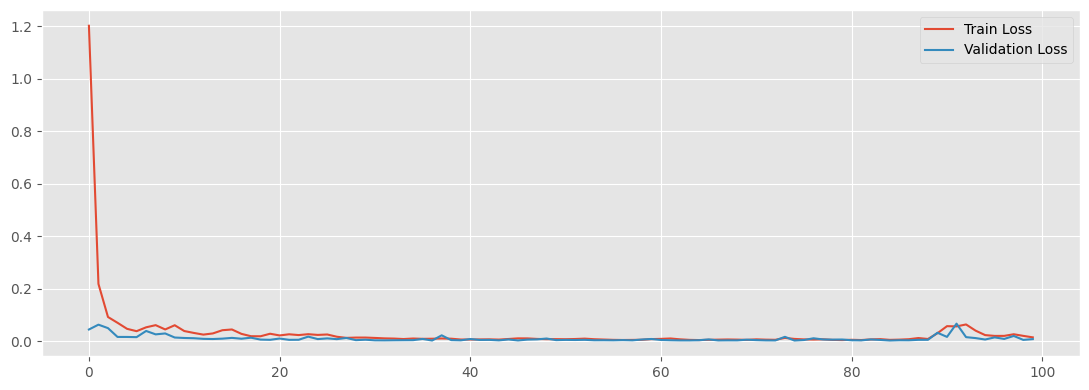

In [53]:
plot_model_history(df_history)

### Validation

In [57]:
# Obtain Predictions
def consume_model(model,features,scaler):
    predictions = model.predict(features)
    predictions = scaler.inverse_transform(predictions) #convert prediction first by inverting the Robust scaler transformation and then the e_logarithmic one.
    predictions = np.exp(predictions)

    predictions = np.concatenate([a[:1] for a in predictions])
    
    return predictions

train_predictions = consume_model(prediction_model,X_train,robust_scaler_targets)
validation_predictions = consume_model(prediction_model,X_validation,robust_scaler_targets)
#test_predictions = consume_model(prediction_model,X_test,robust_scaler_targets)

def calculate_analytical_parameters(actual,predicted):
    x = actual[:len(predicted)]
    y = predicted
    analytical_parameters = {}

    analytical_params = linregress(x, y)

    slope = analytical_params.slope
    intercept = analytical_params.intercept
    rvalue = analytical_params.rvalue
    y_trend_line = slope*x + intercept #this is computed just for the avg_tld
    avg_trend_line_distance = np.mean(np.abs(y_trend_line - y)/y_trend_line)

    analytical_parameters['slope'] = slope
    analytical_parameters['intercept'] = intercept
    analytical_parameters['rvalue'] = rvalue
    analytical_parameters['dispersion'] = avg_trend_line_distance
    analytical_parameters['mse'] = mean_squared_error(x,y) 
    analytical_parameters['rmse'] = np.sqrt(mean_squared_error(x,y))
    analytical_parameters['mape'] = mean_absolute_percentage_error(x,y)
    
    return analytical_parameters

train_analytical_parameters = calculate_analytical_parameters(train_actual_target_list,train_predictions)
validation_analytical_parameters = calculate_analytical_parameters(validation_actual_target_list,validation_predictions)
#test_analytical_parameters = calculate_analytical_parameters(test_actual_target_list,test_predictions)


 4/29 [===>..........................] - ETA: 0s

2/2 [==============================] - 0s 21ms/step


In [55]:
print(f'Train accuracy : \n', train_analytical_parameters)
print(f'Validation accuracy : \n', validation_analytical_parameters)
#print(f'Test accuracy : \n', test_analytical_parameters)

Train accuracy : 
 {'slope': 0.5397443404285741, 'intercept': 93.18626123790452, 'rvalue': 0.9426705527620447, 'dispersion': 0.06843423981697869, 'mse': 1860.8019314159499, 'rmse': 43.13701347353511, 'mape': 0.2795629252062321}
Validation accuracy : 
 {'slope': 0.06575034326242696, 'intercept': 212.18001616251237, 'rvalue': 0.08795052867022761, 'dispersion': 0.043035971404619754, 'mse': 425.97886113402757, 'rmse': 20.639255343495986, 'mape': 0.06692194941295658}


### TPG

{'Comparision': {'trend_slope': 0.5397443404285741,
  'trend_intercept': 93.18626768655943,
  'trend_r2': 0.8886277710446989,
  'dispersion': 0.06843424211113475},
 'Ratio': {'trend_slope': -0.00453847966600295,
  'trend_intercept': 2.0967018391735692,
  'trend_r2': 0.7562069016886097,
  'dispersion': 0.15985632537915762},
 'Scatter': {'trend_slope': 0.5397443404285741,
  'trend_intercept': 93.18626768655943,
  'trend_r2': 0.8886277710446989,
  'dispersion': 0.06843424211113475}}

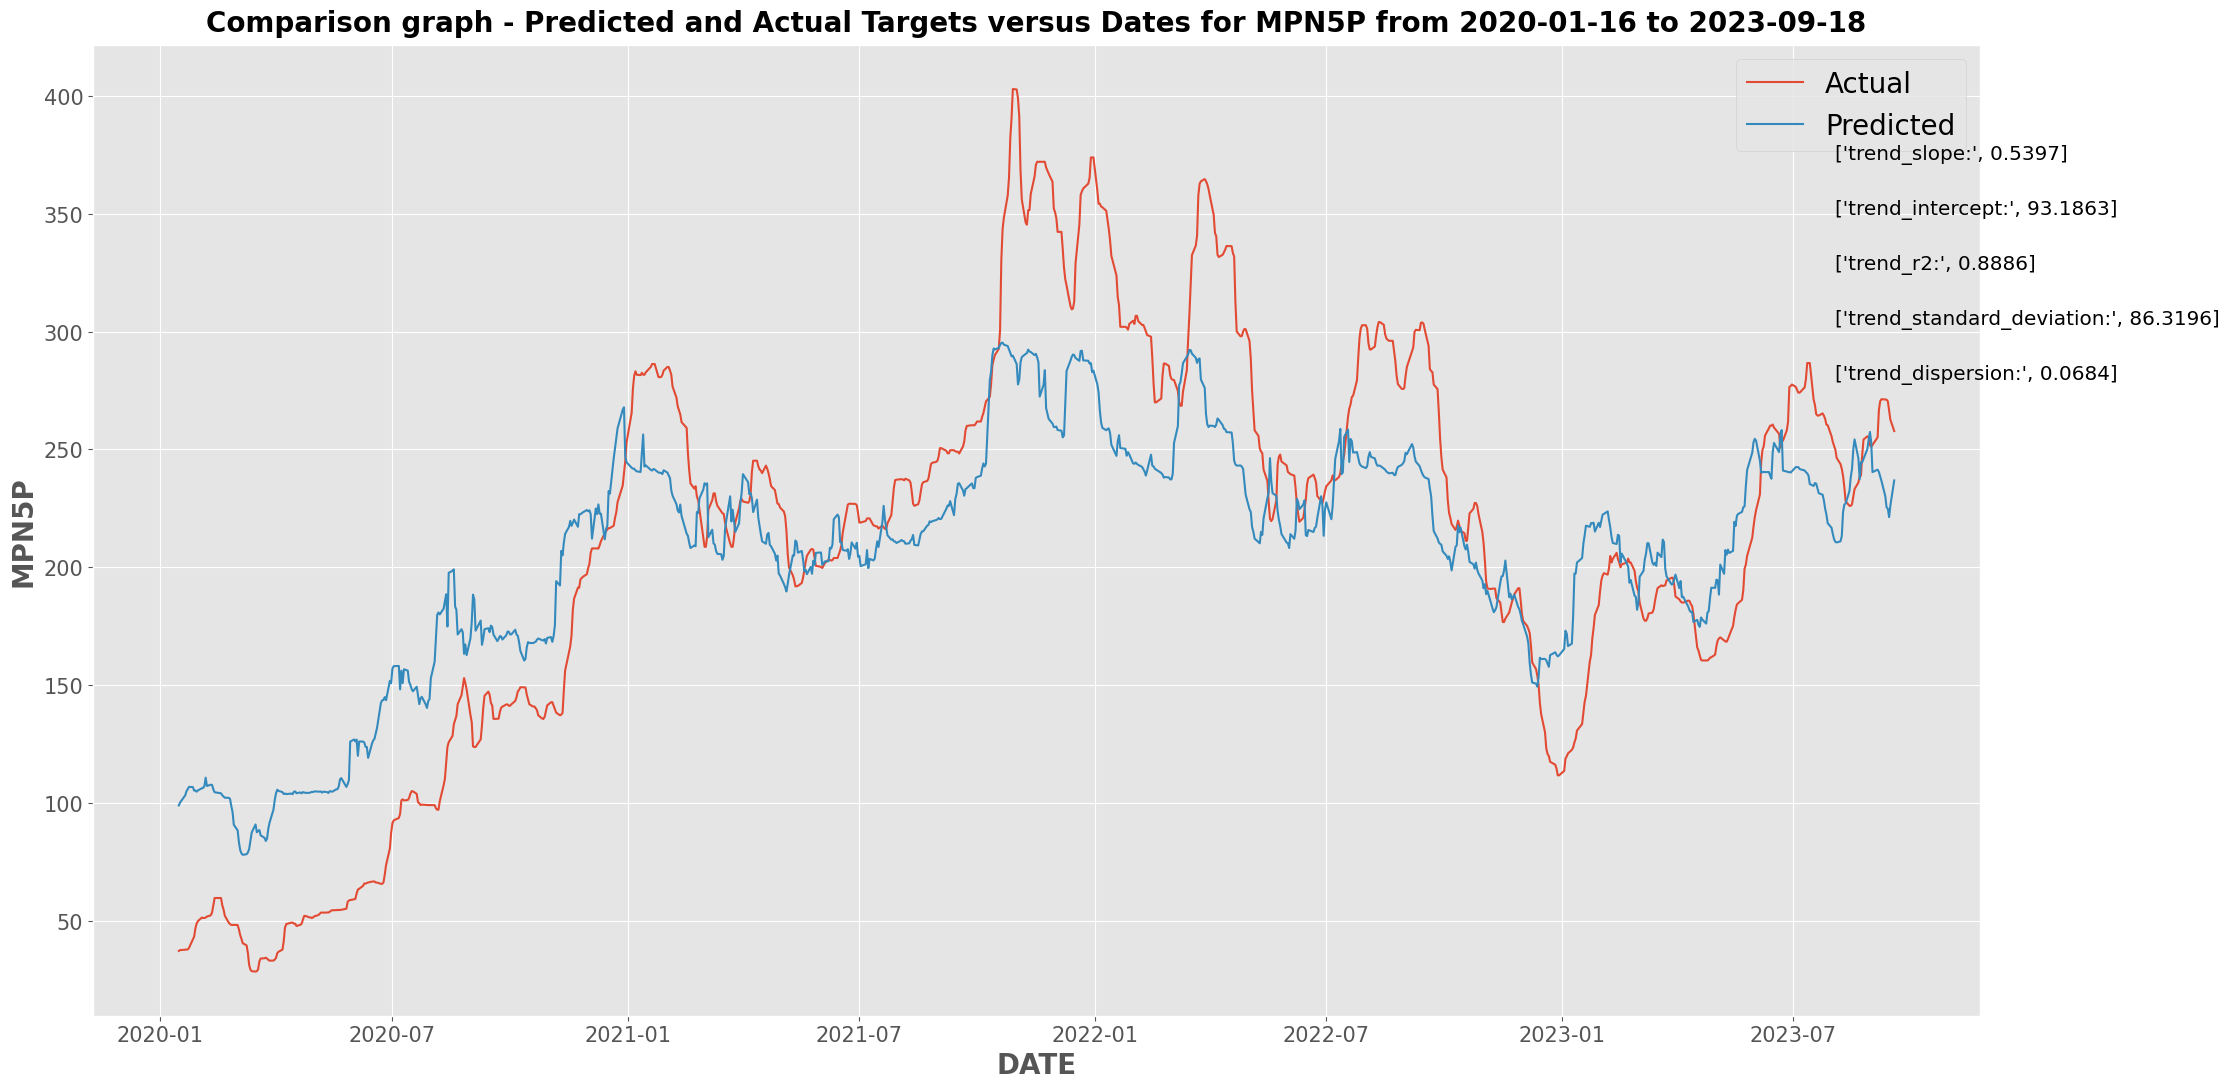

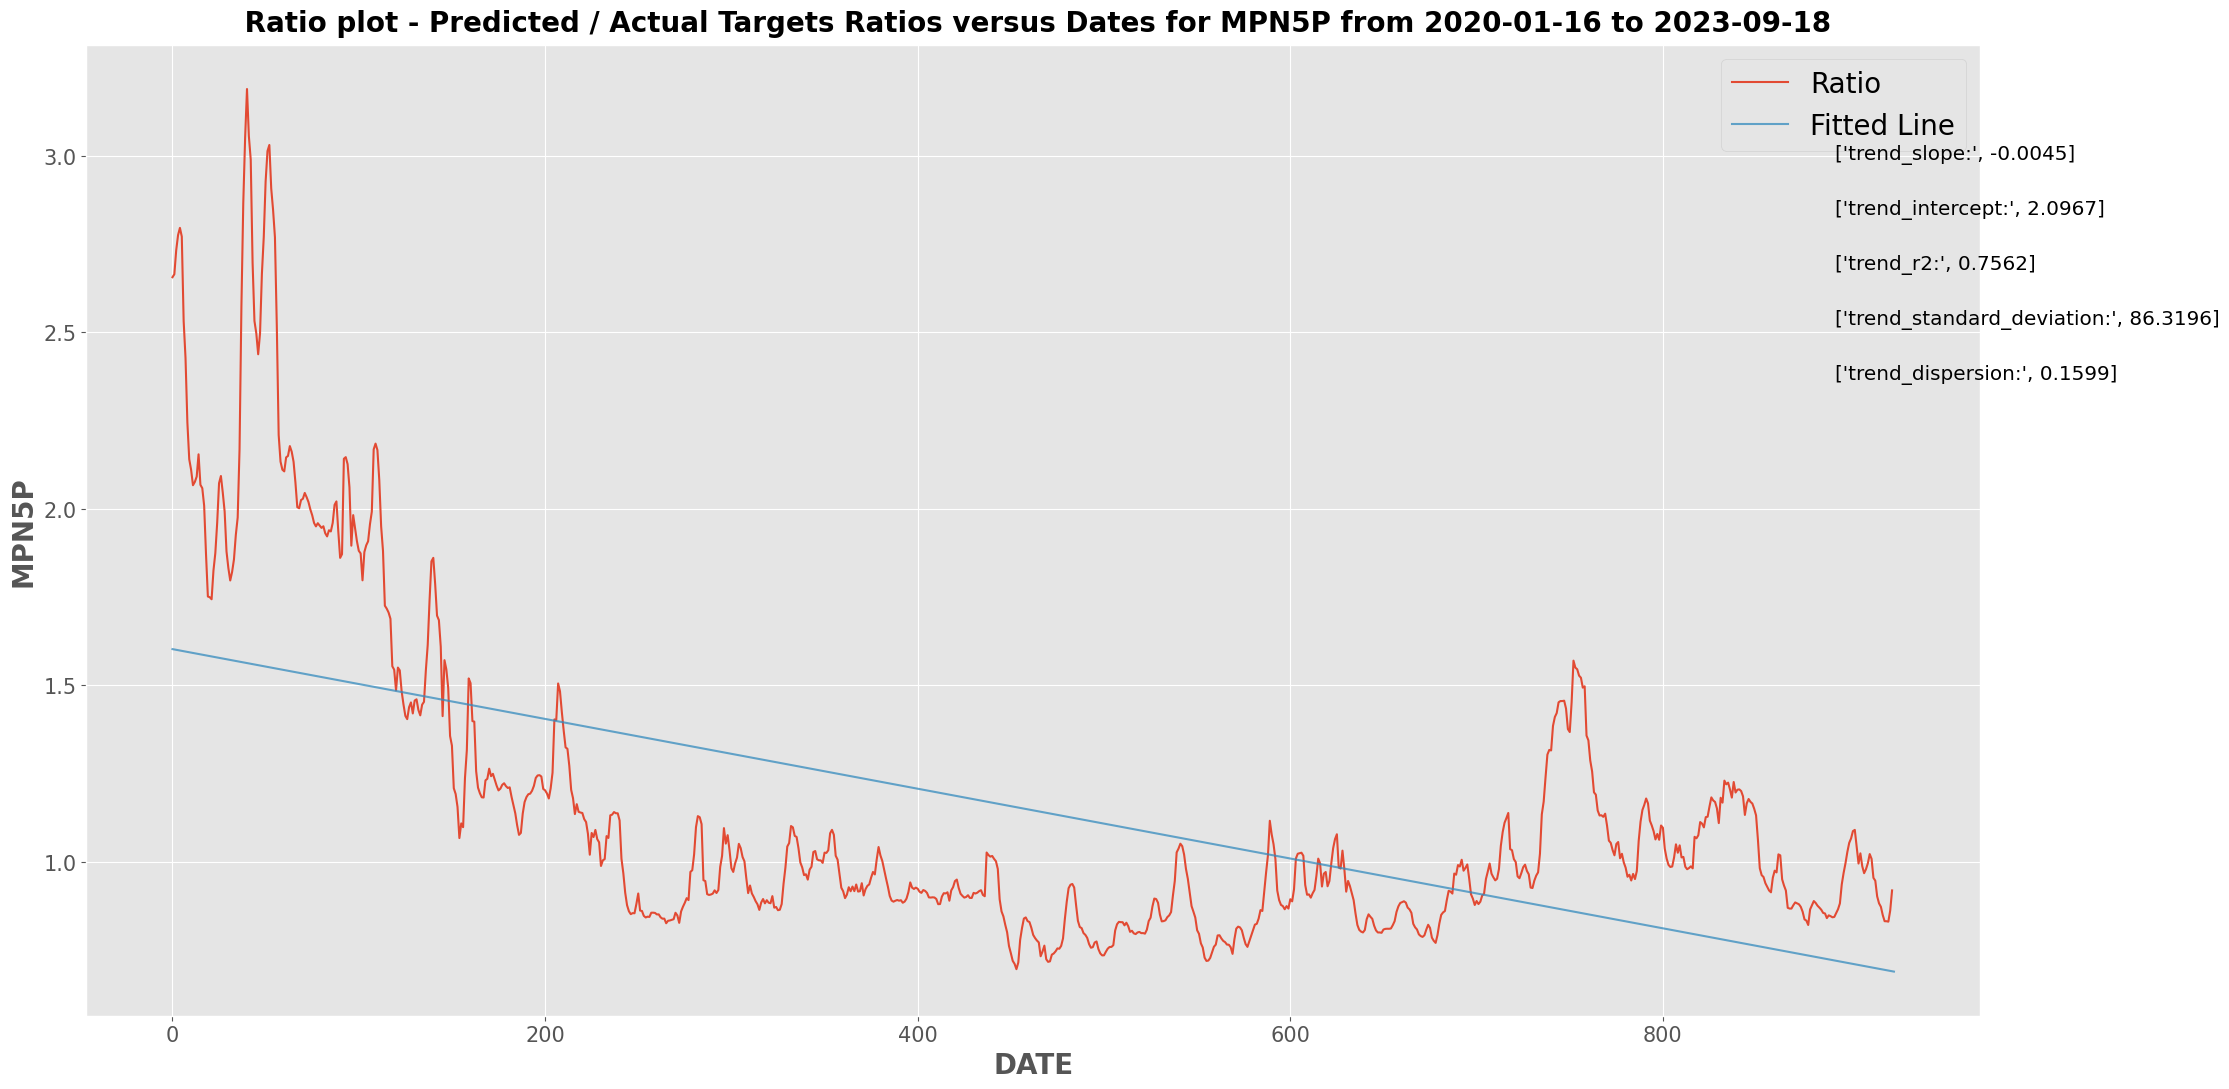

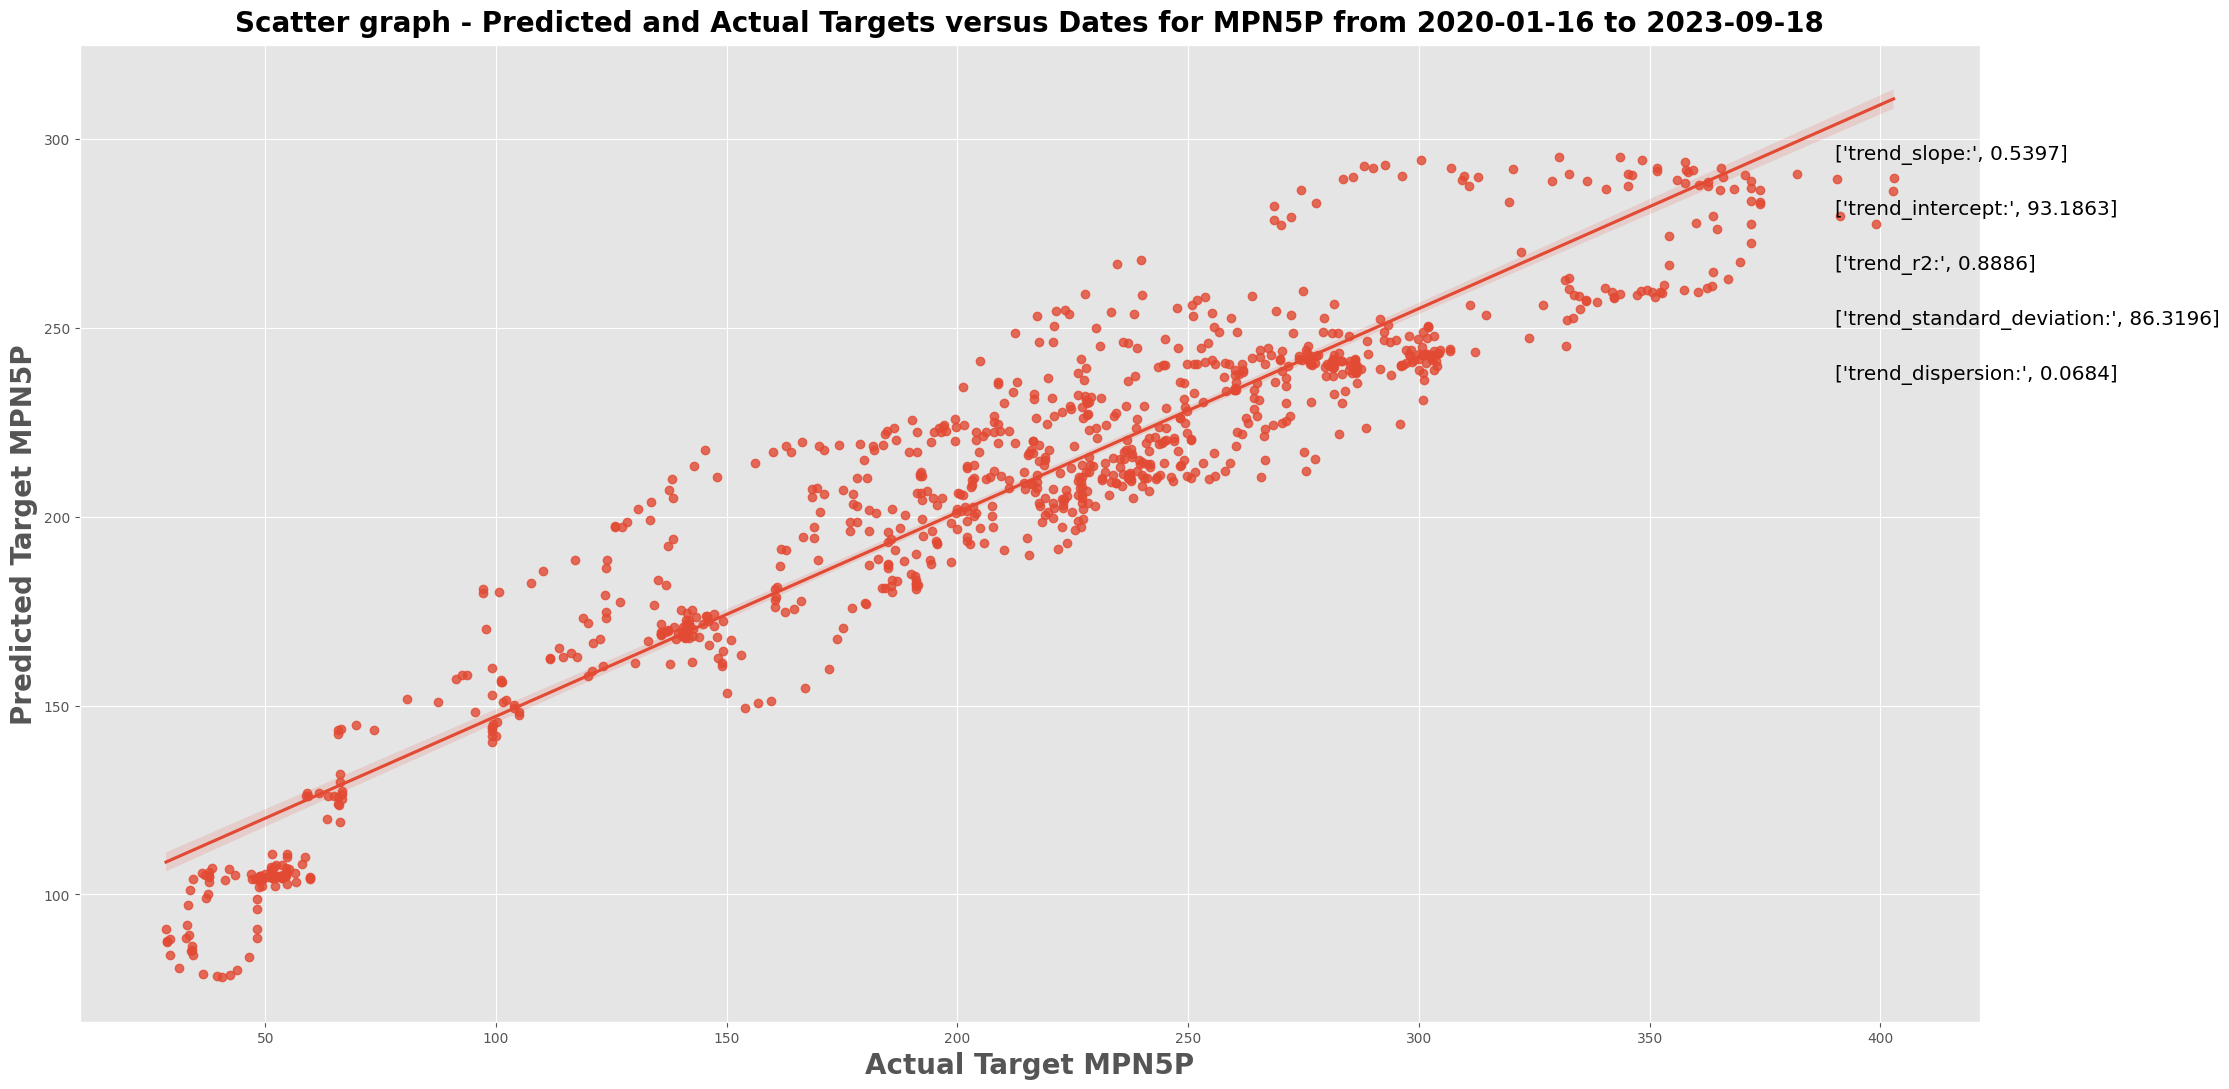

In [61]:
# Train
train_predictions_arr = train_predictions.tolist()
train_actual_target_arr = train_actual_target_list[:len(train_predictions)]

plot_path = str(PLOTS_PATH / f'lmb002_T{timesteps}_E{n_epochs}_B{batch}_train')
dates = [str(pd.to_datetime(date).date()) for date in train_dates_np_arr]
dates = dates[:len(train_predictions)]

generate_plot(predicted_targets=train_predictions_arr,
              actual_targets=train_actual_target_arr,
              plot_path=plot_path,
              dates = dates,
              target='MPN5P')


{'Comparision': {'trend_slope': 0.03407024501750099,
  'trend_intercept': 218.87912559742853,
  'trend_r2': 0.003268466639645314,
  'dispersion': 0.0337431471562858},
 'Ratio': {'trend_slope': -0.0039702712901108425,
  'trend_intercept': 1.902866947326689,
  'trend_r2': 0.7342839396252293,
  'dispersion': 0.03143240521672714},
 'Scatter': {'trend_slope': 0.03407024501750099,
  'trend_intercept': 218.87912559742853,
  'trend_r2': 0.003268466639645314,
  'dispersion': 0.0337431471562858}}

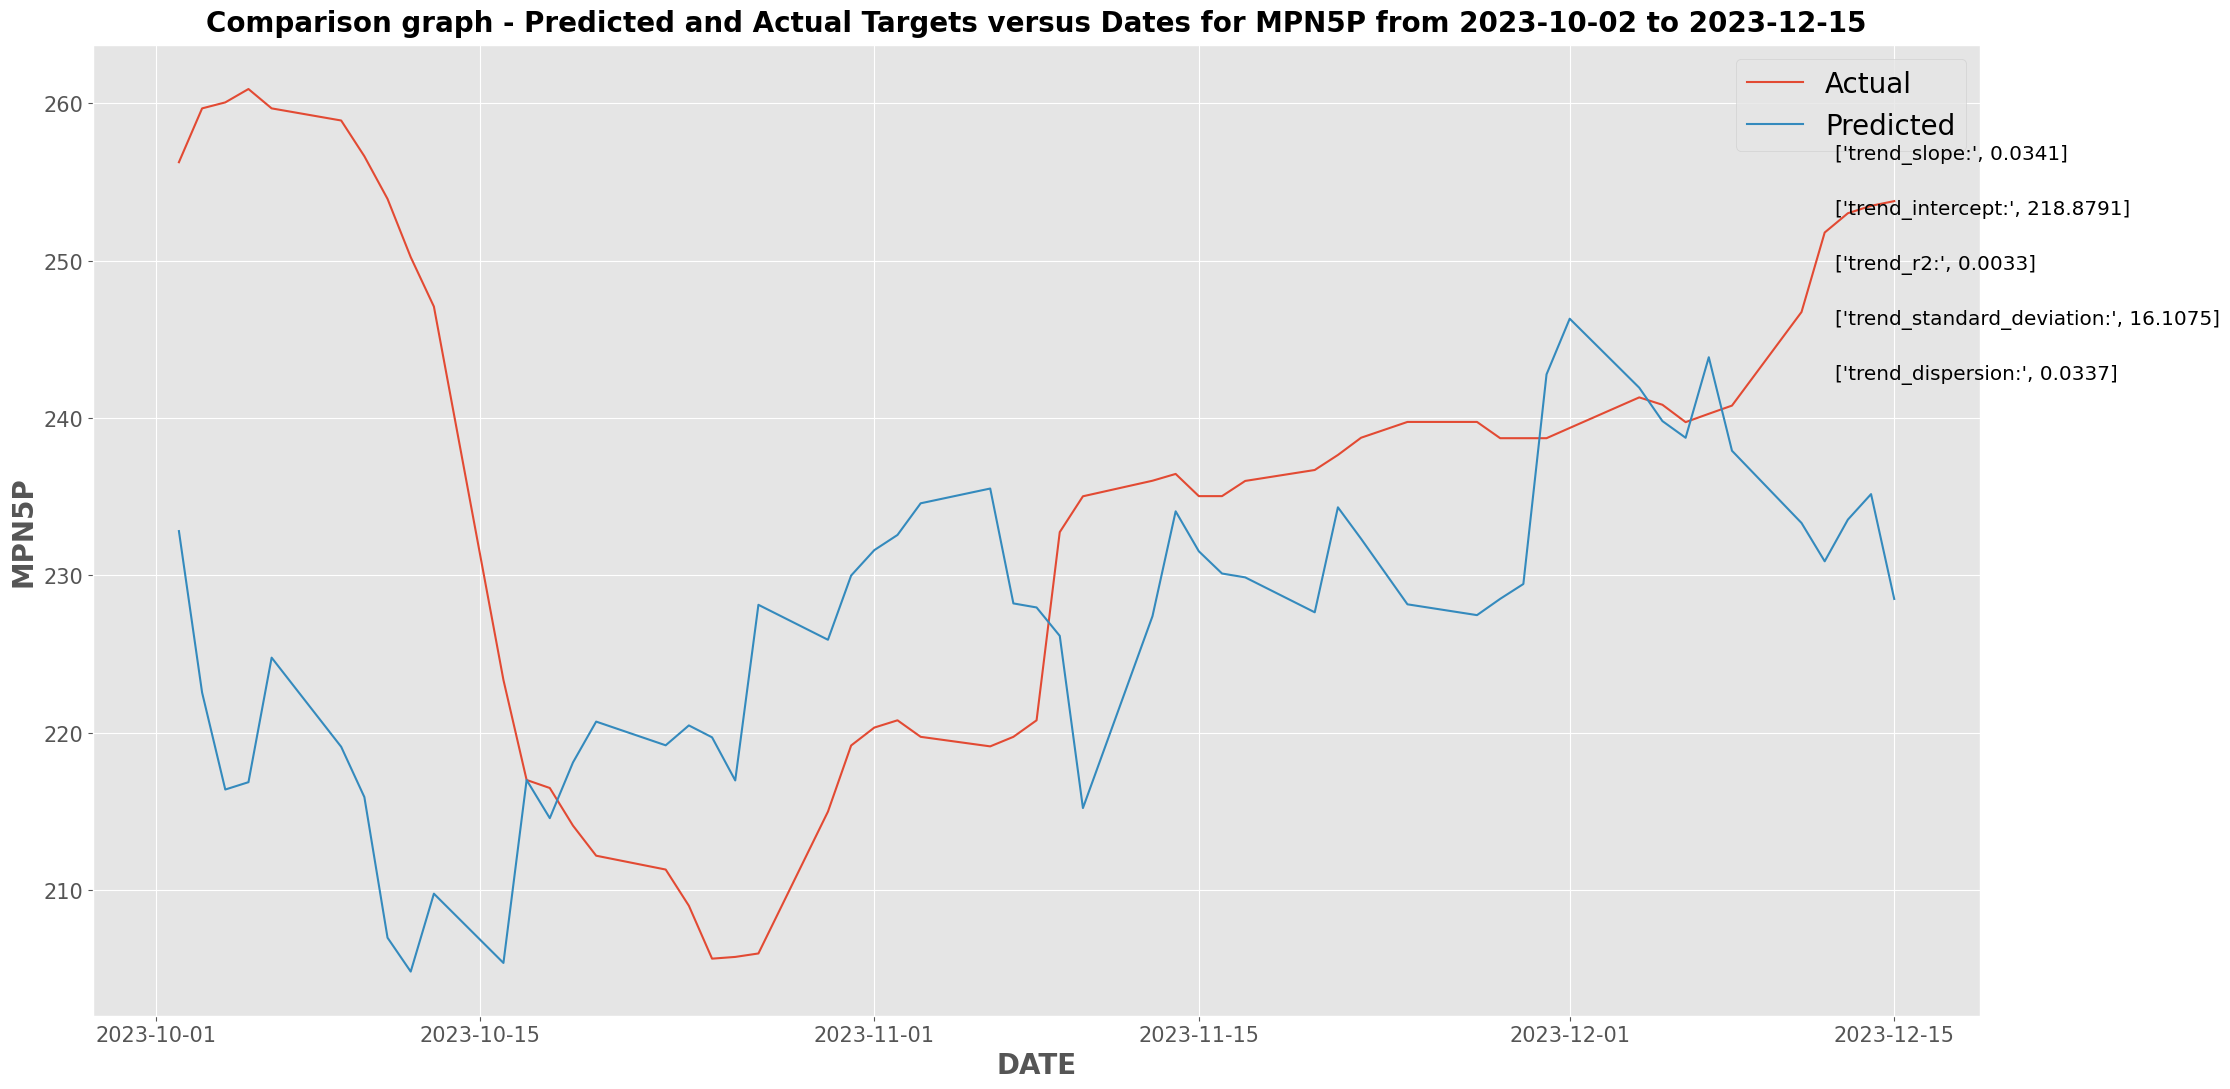

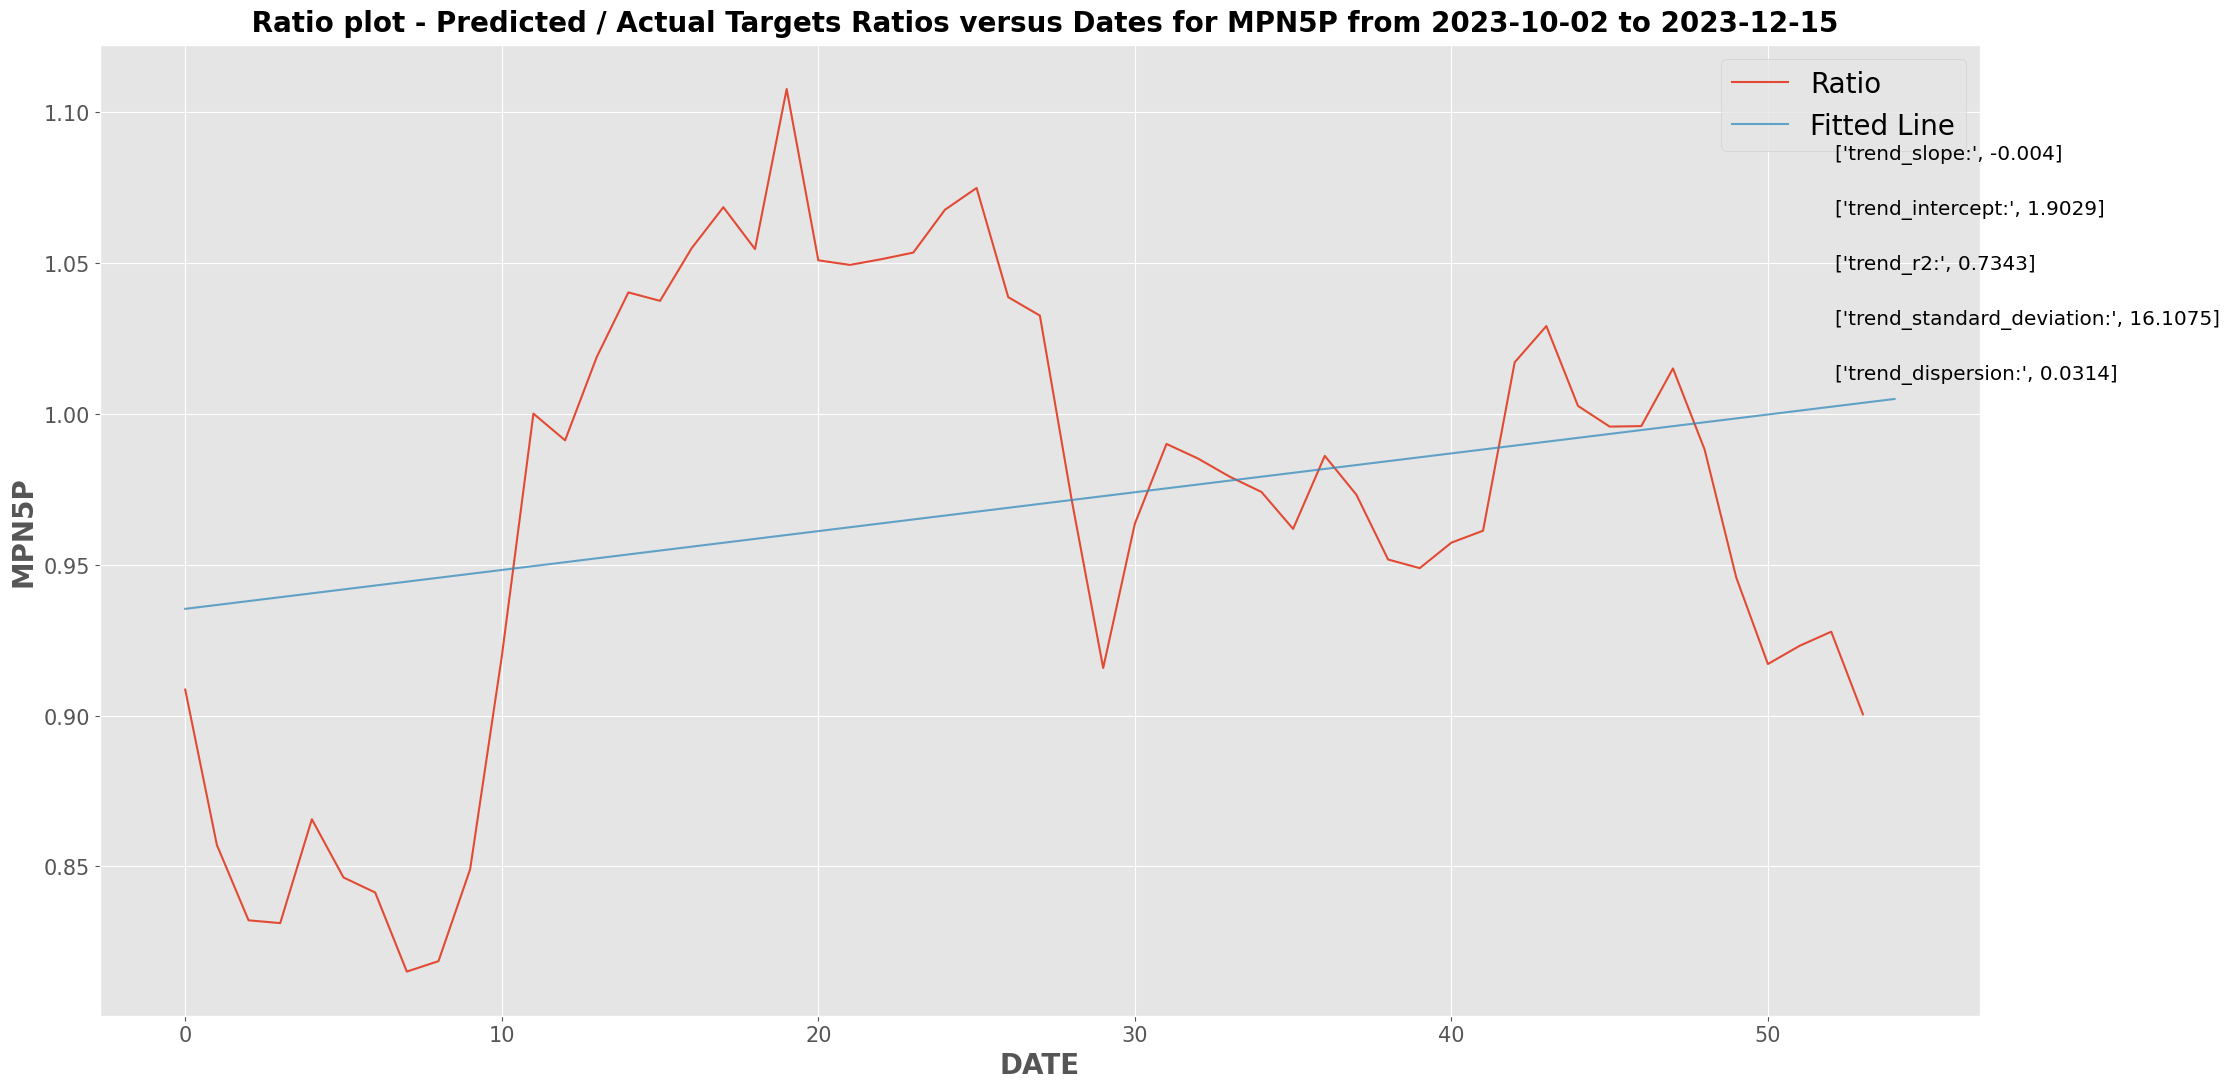

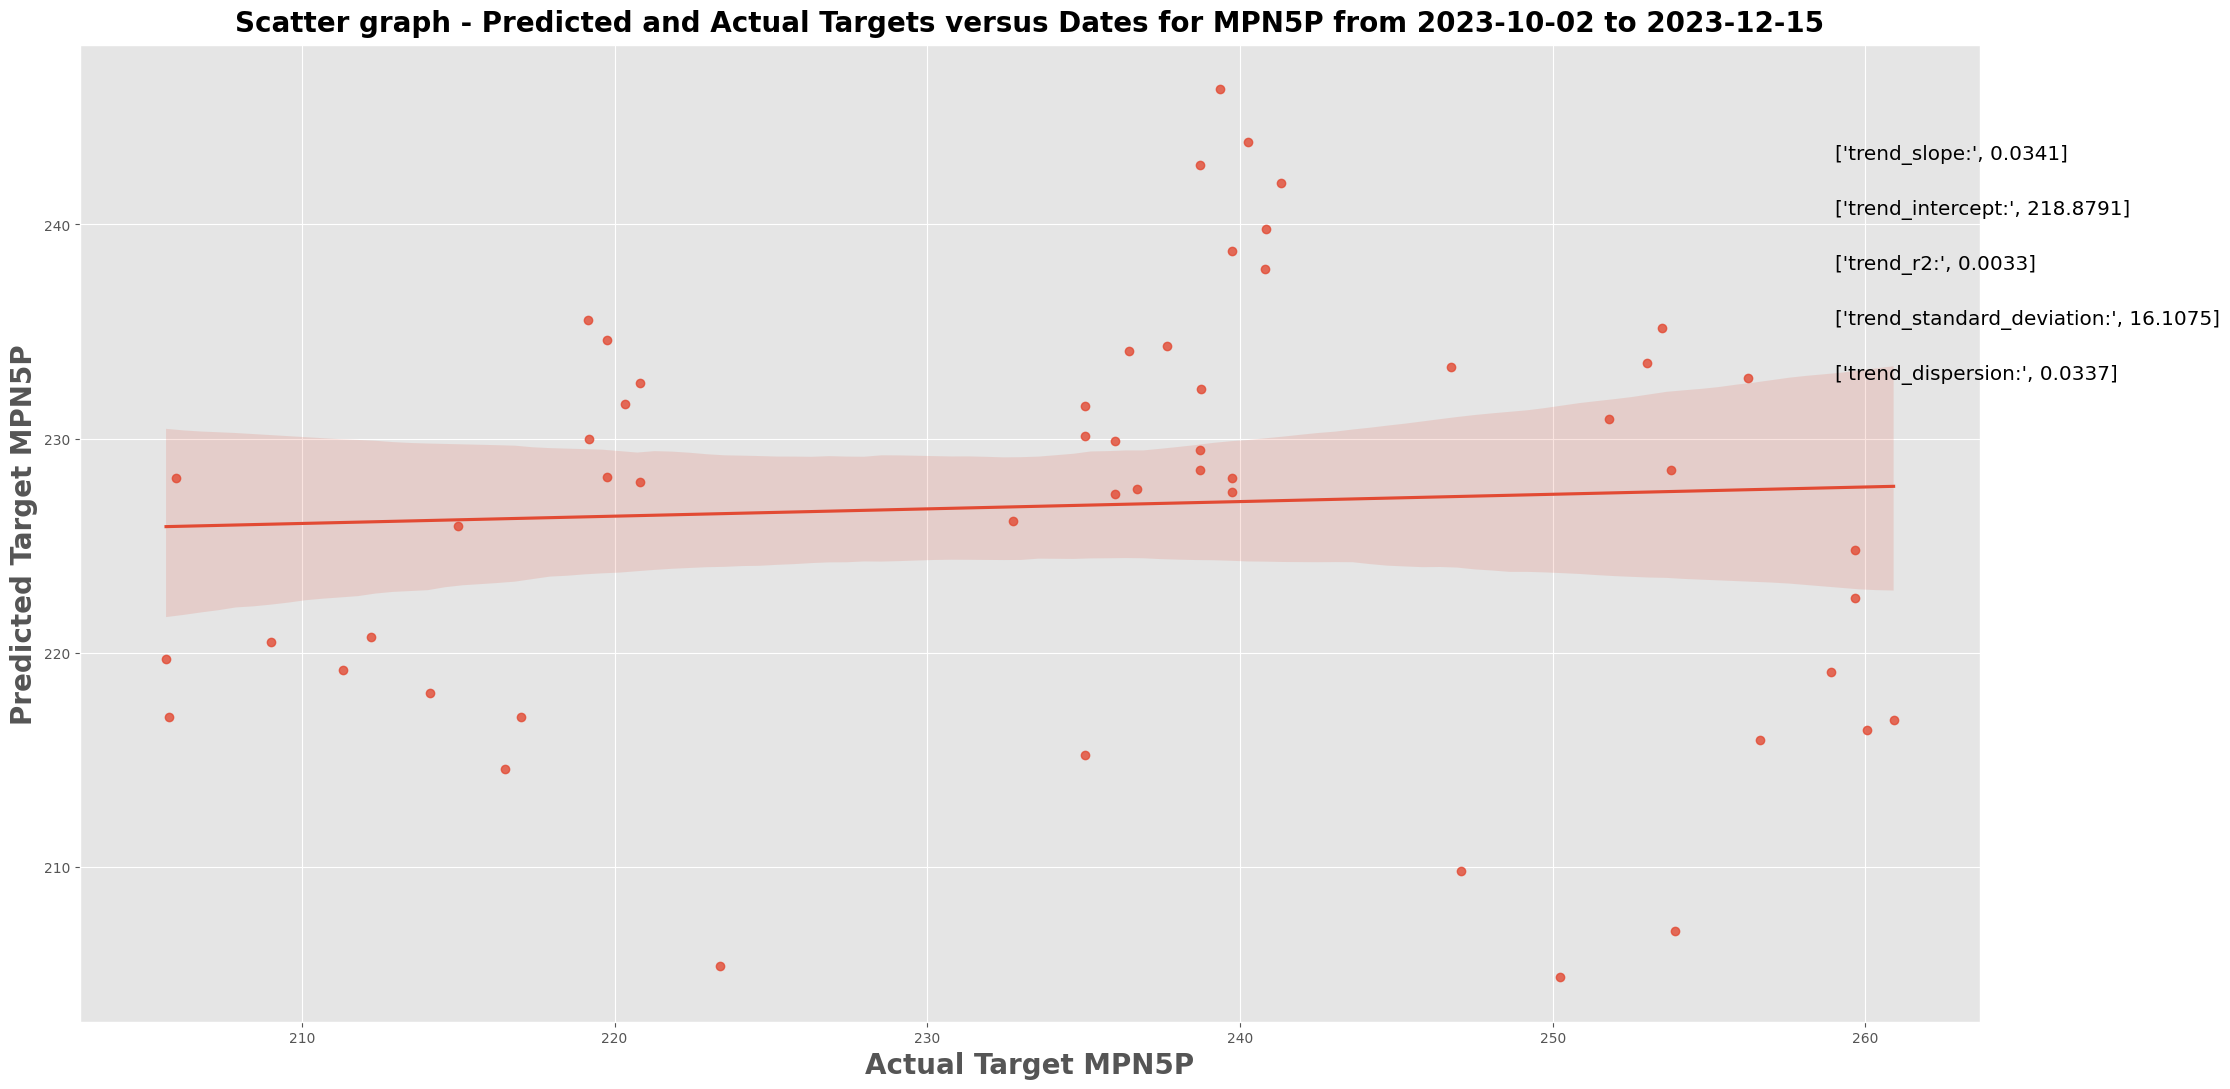

In [ ]:
# Val Set
val_predictions_arr = validation_predictions.tolist()
val_actual_target_arr = validation_actual_target_list[:len(validation_predictions)]

plot_path = str(PLOTS_PATH / f'lmb002_T{timesteps}_E{n_epochs}_B{batch}_validation')
dates = [str(pd.to_datetime(date).date()) for date in validation_dates_np_arr]
dates = dates[:len(validation_predictions)]

generate_plot(predicted_targets=val_predictions_arr,
              actual_targets=val_actual_target_arr,
              plot_path=plot_path,
              dates = dates,
              target='MPN5P')


: 